# Plot correspondences in registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from IPython.display import HTML

from otimage import imagerep, readers
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

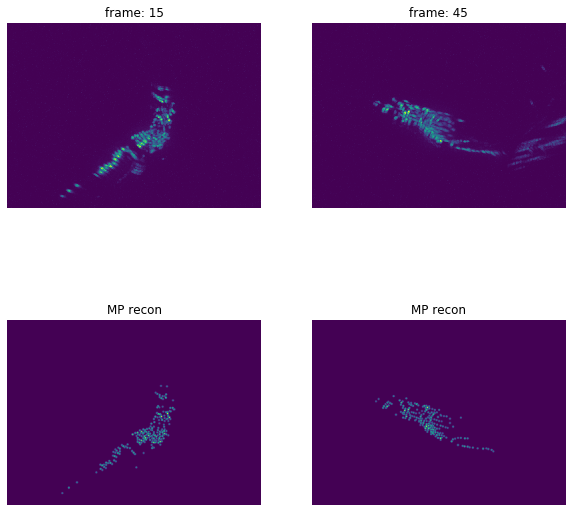

In [3]:
# Frame index
t1 = 15
t2 = 45

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts_1 = mp_data['means'][t1, :, :]
pts_2 = mp_data['means'][t2, :, :]
wts_1 = mp_data['weights'][t1, :, 0]
wts_2 = mp_data['weights'][t2, :, 0]

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute registration for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(pts_2, pts_1, wts_2, wts_1, degree=degree, n_iter=n_iter)

beta = model.named_steps['linear'].coef_
print('beta (est):')
print(beta)

beta (est):
[[-6.37500970e+03  1.46780019e+01  2.70073771e+01 -2.37063720e+01
  -9.45765201e-03 -2.64565759e-02  4.45074674e-02 -2.71933612e-02
   5.97393074e-02 -4.43557853e-01]
 [-2.95479814e+03  7.75364064e+00  1.42227020e+01 -4.11210531e+01
  -4.99815740e-03 -1.78396029e-02  5.07123304e-02 -1.38888059e-02
   8.61879211e-02 -1.79823225e-01]
 [ 4.57879308e+01  2.35539509e-01 -2.67878050e-01 -2.35965444e+00
  -2.35927152e-04 -3.34157564e-04  1.09924379e-03  4.24452562e-04
   4.16954820e-03  2.10195408e-02]]


## Compute pullback with identified MP component

In [5]:
# Transform MP points for second image using mapping
pb_pts = model.predict(pts_2).astype(int)

# Reconstruct image from transformed points
rec_pb = imagerep.reconstruct_image_2(pb_pts, wts_2, cov, img_shape)

## Plot pullback and MP components

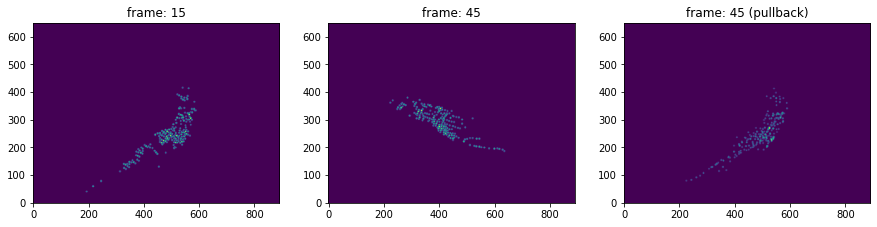

In [6]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(rec_pb)
plt.title(f'frame: {t2} (pullback)');

In [7]:
def plot_mp(idx):
    
    mp_pt = pts_2[idx]
    mp_pb = pb_pts[idx]
   
    fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(15, 15))

    plot_maxproj(rec_1, ax_1)
    ax_1.set_title(f'frame: {t1}')
        
    plot_maxproj(rec_2, ax_2)
    ax_2.plot(mp_pt[0], mp_pt[1], color='red', marker='*')
    ax_2.set_title(f'frame: {t2}')
        
    plot_maxproj(rec_pb, ax_3)
    ax_3.plot(mp_pb[0], mp_pb[1], color='red', marker='*')
    ax_3.set_title(f'frame: {t2} (pullback)');


ipyw.interact(
    plot_mp, 
    idx=ipyw.IntSlider(
        min=0, max=pts_1.shape[0], step=1, 
        continuous_update=False, description='MP:'
    )
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='MP:', max=200), Output()), _dom…

## Notes

### Correspondence accuracy

(all registrations were run with `n_iter=50`

#### OT registration, quadratic model

- Ran on frames 3 and 4, and correspondence was accurate
- Ran on frames 3 and 10, and correspondence was not accurate
- Example indices where MPs are poorly matched: 5, 7, 8, 15, 17, 19, 25, 28

#### OT registration, cubic model

- Ran on frames 3 and 10, and correspondence was not accurate, but might be better than quadratic model
- Example indices where MPs are poorly matched: 2, 3, 8, 10, 13, 31, 33

#### GW registration, quadratic model

- Ran on frames 3 and 4, and correspondence was accurate
- Ran on frames 3 and 10, and correspondence was accurate
- Ran on frames 15 and 45, and correspondence was accurate (this is crazy -- frames are extremely different)